<a href="https://colab.research.google.com/github/GPhMorin/geneo/blob/main/examples/correlation_mds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Correlation computation and visualization

This script computes pairwise relationship correlation of the probands from the **genea140** dataset and plots the individuals based on those correlations.

In [35]:
!python --version

Python 3.10.12


The GENEO toolkit will be used for loading the datasets, identifying the probands, and computing the pairwise kinship coefficients.

In [36]:
%pip install umap-learn scikit-bio https://github.com/GPhMorin/geneo/archive/main.zip

  Using cached https://github.com/GPhMorin/geneo/archive/main.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [37]:
import numpy as np
import pandas as pd
from skbio.stats.ordination import pcoa
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import geneo as gen
from itertools import combinations
import umap

Two datasets will be used: the **genea140** dataset, which according to the [GENLIB reference manual](https://cran.r-project.org/web/packages/GENLIB/GENLIB.pdf) corresponds to:
> "A genealogical corpus made of 41523 individuals from the province of Quebec, Canada. A total of 140 individuals have been sampled in seven sub-populations, listed in pop140, and their genealogies were reconstructed as far back as possible using the BALSAC population register and the Early Quebec Population Register.

In [38]:
genea140 = gen.genealogy(gen.genea140)
genea140

A pedigree with:
41523 individuals;
68248 parent-child relations;
20773 men;
20750 women;
140 probands;
18 generations.

The other dataset is **pop140** and accompanies **genea140**. According to the GENLIB reference manual:
> The 140 individuals from the genealogical corpus from Quebec were sampled from 7 different populations from 5 regions; Quebec City, Montreal, Saguenay, North Shore, Gaspesia. In Gaspesia we find 3 different populations: French-Canadians, Acadians and Loyalists.

In [39]:
pop140 = pd.read_csv(gen.pop140, sep='\t')
pop140.iloc[:10, :]

,ind,pop
0,409682,Saguenay
1,409687,Saguenay
2,868387,Saguenay
3,717537,Saguenay
4,302711,Saguenay
5,302716,Saguenay
6,868572,Saguenay
7,717634,Saguenay
8,409808,Saguenay
9,718567,Saguenay


Now let's compute the pairwise correlations. On a recent computer, it should take just a few seconds to run the next line, especially if you have OpenMP detected during the toolkit's installation.

In [40]:
corr = gen.corr(genea140)
corr.iloc[:5, :5]

,217891,218089,219947,288708,288764
217891,1.000000,0.000470,0.011566,0.010293,0.016159
218089,0.000470,1.000000,0.000540,0.000459,0.000457
219947,0.011566,0.000540,1.000000,0.012654,0.014624
288708,0.010293,0.000459,0.012654,1.000000,0.016052
288764,0.016159,0.000457,0.014624,0.016052,1.000000


In another situation where the genealogies are bigger, you can run `gen.phi(genea140, compute=False)` to get information about the minimum RAM required.

In [41]:
gen.phi(genea140, compute=False)

You will require at least 2.84 GB of RAM.


Let's embed the data into two-dimensional space.

In [42]:
results = pcoa(1 - corr)
emb = results.samples.to_numpy()
emb[:10, :]

array([[-5.18105606e-02,  9.52585285e-02, -1.27600190e-02, ...,
        -2.65104218e-03, -1.20825912e-03, -0.00000000e+00],
       [ 3.56952569e-03, -5.88882471e-02,  2.20050785e-02, ...,
        -2.17729879e-03, -3.61796461e-04, -0.00000000e+00],
       [-8.67232735e-02,  6.55693182e-02, -2.77563198e-03, ...,
        -2.57800453e-03,  9.40230469e-04, -0.00000000e+00],
       ...,
       [-1.19595318e-01,  1.09163640e-01, -6.96378383e-03, ...,
        -1.49170941e-04,  1.65735317e-05, -0.00000000e+00],
       [-1.36675030e-01,  1.29893827e-01, -9.70484849e-03, ...,
        -7.28436338e-04,  3.22599286e-04, -0.00000000e+00],
       [-1.01432945e-01,  8.40463200e-02, -1.05685540e-03, ...,
        -1.61547503e-04, -1.08776409e-04, -0.00000000e+00]])

In [43]:
ratios = results.proportion_explained
ratios

,0
PC1,0.013699
PC2,0.011331
PC3,0.008993
PC4,0.008531
PC5,0.008257
...,...
PC136,0.006397
PC137,0.006293
PC138,0.006169
PC139,0.005533


Probands are identified using the `gen.pro` function.

In [44]:
pro = gen.pro(genea140)
pro[:10]

[217891,
 218089,
 219947,
 288708,
 288764,
 302710,
 302711,
 302716,
 302717,
 302718]

For each proband, we obtain their corresponding population from the **pop140** dataset.

In [45]:
populations = [pop140.loc[pop140['ind'] == ind, 'pop'].iloc[0] for ind in pro]
populations[:10]

['Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay']

For each population, we get the corresponding abbreviation.

In [46]:
population_to_pop = {
    'Gaspesia-Acadian': 'ACA',
    'Gaspesia-FrenchCanadian': 'GFC',
    'Gaspesia-Loyalist': 'LOY',
    'Montreal': 'MON',
    'NorthShore': 'NS',
    'Quebec': 'QUE',
    'Saguenay': 'SAG'
}

For each abbreviation, we get the corresponding color.

In [47]:
pop_to_color = {
    'ACA': 'red',
    'GFC': 'purple',
    'LOY': 'lime',
    'MON': 'orange',
    'NS': 'cyan',
    'QUE': 'blue',
    'SAG': 'darkgreen',
}

Let's extract the color for each proband.

In [48]:
colors = [pop_to_color[population_to_pop[population]]
          for population in populations]
colors[:10]

['darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen']

Finally, let's see the results.

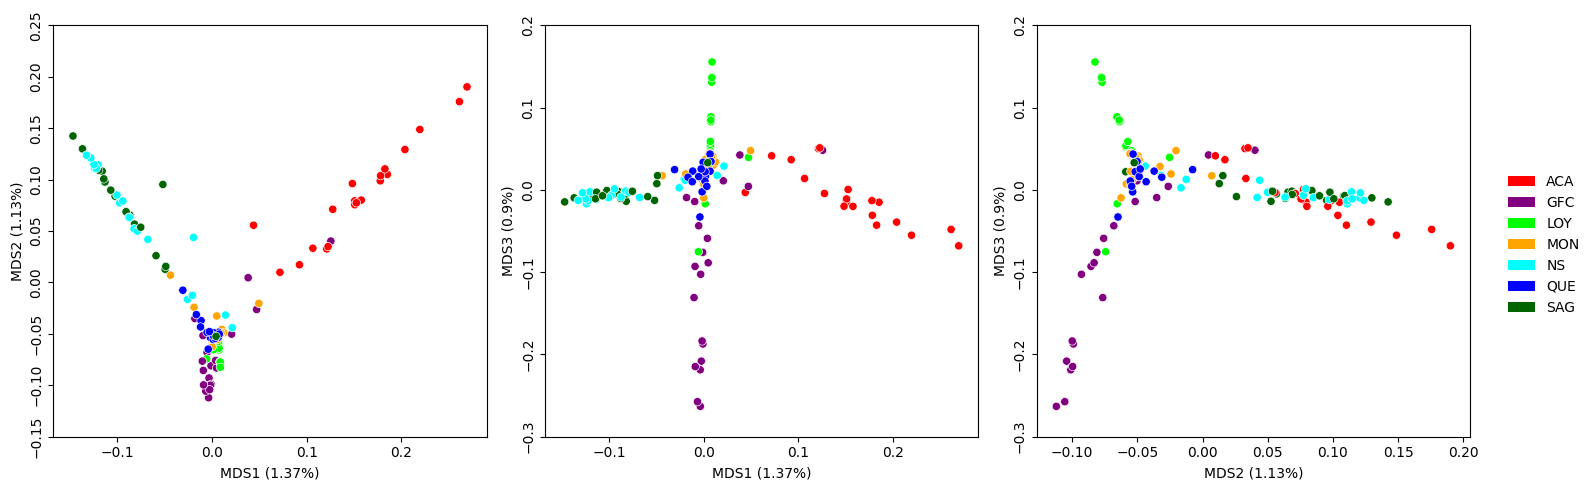

In [49]:
comb = list(combinations(range(3), 2))

rows = len(comb) // 3
cols = 3 + len(comb) % 3
fig, axes = plt.subplots(rows, cols, figsize=(cols/rows * 5, 5))

# Loop through combinations and plot
for index, (i, j) in enumerate(comb):
    ax = axes.flat[index]
    sp = sns.scatterplot(
        x=emb[:, i], y=emb[:, j], hue=colors, ax=ax,
        palette={color: color for color in pop_to_color.values()})
    ratio = round(ratios.iloc[i] * 100, 2)
    ax.set_xlabel(f'MDS{i+1} ({ratio}%)')
    ratio = round(ratios.iloc[j] * 100, 2)
    ax.set_ylabel(f'MDS{j+1} ({ratio}%)')

    # Rotate the y axis labels
    yticks = ax.get_yticks()
    yticklabels = ax.get_yticklabels()
    ax.set_yticks(yticks, yticklabels, va='center', rotation=90)

    # Disable legend
    sp.get_legend().remove()

# Create a list of legend elements
legend_elements = [Patch(facecolor=color, label=pop)
                   for pop, color in pop_to_color.items()]

# Legend outside the plot
legend_handle = fig.legend(handles=legend_elements, bbox_to_anchor=(1.0, 0.5),
                           loc='center left', frameon=False)

plt.tight_layout()
plt.show()

The results are comparable to those of the MDS of figure 2 from the article by Roy-Gagnon et al. (2011) <[https://doi.org/10.1007/s00439-010-0945-x]()>.

Let's see if it is possible to see a finer structure.

In [50]:
dist = -np.log2(corr)
dist.replace(np.inf, np.nan, inplace=True)
while dist.isnull().sum().sum() > 0:
    null_counts = dist.isnull().sum(axis = 1)
    individuals_to_remove = null_counts[null_counts == null_counts.max()].index
    dist = dist.drop(index=individuals_to_remove)
    dist = dist.drop(columns=individuals_to_remove)
dist.shape

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


(123, 123)

In [51]:
populations = [pop140.loc[pop140['ind'] == ind, 'pop'].iloc[0]
               for ind in dist.index]
populations[:10]

['Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay']

In [52]:
results = pcoa(dist)
emb = results.samples.to_numpy()
emb[:10, :]

/usr/local/lib/python3.10/dist-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -246.8303862144895 and the largest is 1508.9966856709418.
  warn(


array([[ 0.14792588,  3.59497143,  0.72434553, ...,  0.        ,
         0.        ,  0.        ],
       [-1.83406481, -4.49268863, -2.99844026, ...,  0.        ,
         0.        ,  0.        ],
       [-2.87175366,  2.12852651,  0.24621786, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.70192307,  2.52260176,  0.59536517, ...,  0.        ,
         0.        ,  0.        ],
       [-5.11369575,  2.46179768, -0.59829205, ...,  0.        ,
         0.        ,  0.        ],
       [-3.69767899,  2.46439988,  0.32820226, ...,  0.        ,
         0.        ,  0.        ]])

In [53]:
ratios = results.proportion_explained
ratios

,0
PC1,0.217158
PC2,0.094861
PC3,0.070234
PC4,0.033824
PC5,0.029562
...,...
PC119,0.000000
PC120,0.000000
PC121,0.000000
PC122,0.000000


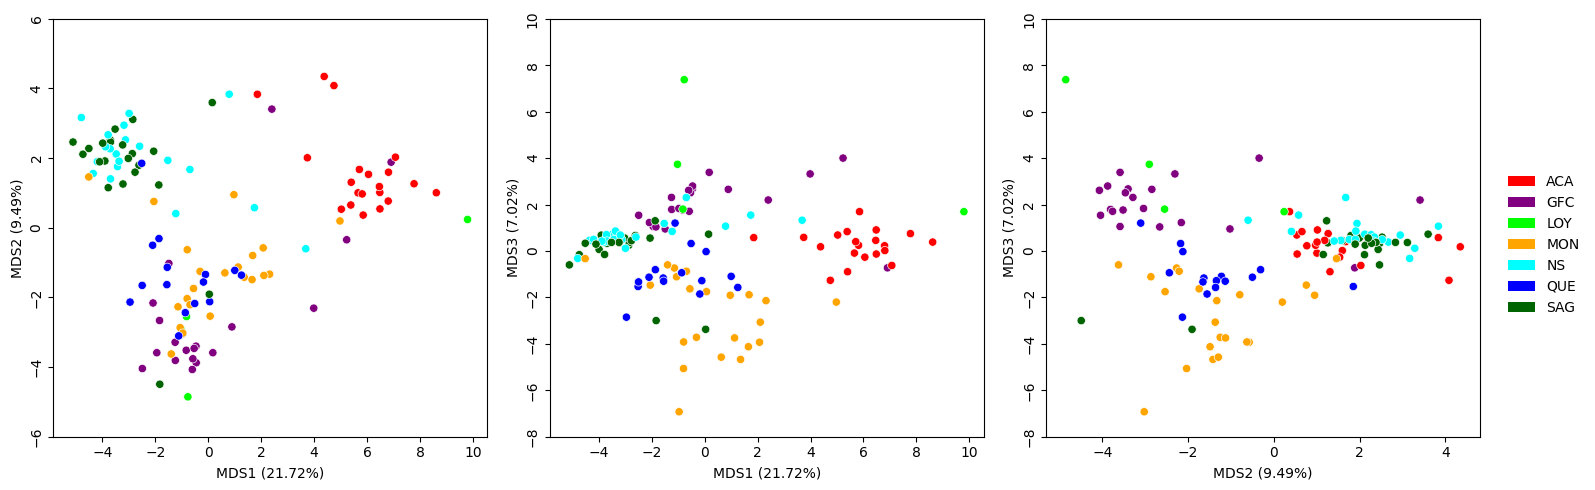

In [54]:
comb = list(combinations(range(3), 2))

rows = len(comb) // 3
cols = 3 + len(comb) % 3
fig, axes = plt.subplots(rows, cols, figsize=(cols/rows * 5, 5))

colors = [pop_to_color[population_to_pop[population]]
          for population in populations]

# Loop through combinations and plot
for index, (i, j) in enumerate(comb):
    ax = axes.flat[index]
    sp = sns.scatterplot(
        x=emb[:, i], y=emb[:, j], hue=colors, ax=ax,
        palette={color: color for color in pop_to_color.values()})
    ratio = round(ratios.iloc[i] * 100, 2)
    ax.set_xlabel(f'MDS{i+1} ({ratio}%)')
    ratio = round(ratios.iloc[j] * 100, 2)
    ax.set_ylabel(f'MDS{j+1} ({ratio}%)')

    # Rotate the y axis labels
    yticks = ax.get_yticks()
    yticklabels = ax.get_yticklabels()
    ax.set_yticks(yticks, yticklabels, va='center', rotation=90)

    # Disable legend
    sp.get_legend().remove()

# Legend outside the plot
legend_handle = fig.legend(handles=legend_elements, bbox_to_anchor=(1.0, 0.5),
                           loc='center left', frameon=False)

plt.tight_layout()
plt.show()

In [55]:
X = umap.UMAP(metric='precomputed').fit_transform(dist)
X[:10, :]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


array([[13.31895 , 18.912014],
       [ 8.372173, 17.215796],
       [13.018048, 18.192953],
       [13.738921, 17.987736],
       [13.463378, 18.311754],
       [13.099065, 18.11742 ],
       [13.546266, 17.543264],
       [13.751391, 17.893452],
       [13.735262, 18.44605 ],
       [13.884903, 18.319376]], dtype=float32)

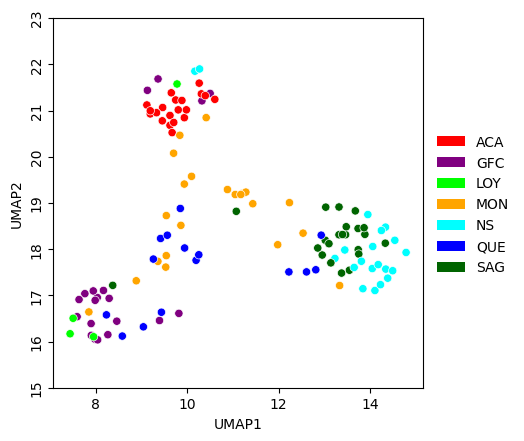

In [56]:
sp = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=colors,
                     palette={color: color for color in pop_to_color.values()})
sp.set_box_aspect(1)
sp.set_xlabel(f'UMAP1')
sp.set_ylabel(f'UMAP2')

# Get the current axis
x0, y0, w, h = sp.get_position().bounds

# Rotate the y axis labels
yticks = sp.get_yticks()
yticklabels = sp.get_yticklabels()
sp.set_yticks(yticks, yticklabels, va='center', rotation=90)

# Create a list of legend elements
legend_elements = [Patch(facecolor=color, label=pop)
                   for pop, color in pop_to_color.items()]

# Add the legend to the plot
sp.legend(handles=legend_elements, bbox_to_anchor=(x0 / 2 + w * 2, y0 + h / 2),
          loc='right', frameon=False)
plt.show()